In [5]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

data_key = 'ml-1m/'
# data_key = 'amz_Books/'
# data_key = 'amz_Movies_and_TV/'
# data_key = 'amz_Electronics/'
PROCESSED_DATA_ROOT = "/home/sl1471/workspace/experiments/"
target_path = PROCESSED_DATA_ROOT + data_key

### 1. Extract Results from Logs

In [6]:
from utils import extract_results
log_path = target_path + "logs/"
control_args = ['lr', 'l2_coef', 'fair_group_feature', 'fair_lambda', 'fair_noise_sigma', 'n_local_step']
results = extract_results(log_path, control_args, "f2rec_train_and_eval")
print(results.keys())

82it [00:00, 1559.11it/s]

f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.1_sigma0_gactivity.log
f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.5_gactivity.log
f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0_sigma0_gactivity.log
f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.7_sigma0_gactivity.log
f2rec_train_and_eval_FedMF_lr0.01_reg0.1_losspairwisebpr_local1_fedavg.log
f2rec_train_and_eval_FedMF_lr0.003_reg0.1_losspairwisebpr_local3_fedavg.log
f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.3_sigma0_gactivity.log
f2rec_train_and_eval_FedMF_lr0.001_reg0.1_losspairwisebpr_local1_fedavg.log
f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.3_sigma0_gactivity.log
f2rec_train_and_eval_MF_lr0.00003_reg0.1_losspairwisebpr.log
f2rec_train_and_eval_MF_lr0.00001_reg0.1_losspairwisebpr.log
f2rec_train_and_eval_MF_lr0.0001_reg0.1_losspairwisebpr.log
f2rec_train_and_eval_FairFedMF_lr0.003_reg

In [7]:
import json
print("Example:")
print(json.dumps(list(results.values())[0], indent = 4))

Example:
{
    "args": "cuda=2, seed=29, train=False, train_and_eval=True, continuous_train=False, eval=False, model_path='/home/sl1471/workspace/experiments/ml-1m/models/f2rec_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.1_sigma0_gactivity.pkl', loss='pairwisebpr', l2_coef=0.1, emb_size=32, device_dropout_p=0.1, device_dropout_type='same', n_local_step=1, random_local_step=False, aggregation_func='fedavg', mitigation_trade_off=1.0, elastic_mu=0.01, data_file='/home/sl1471/workspace/experiments/ml-1m/tsv_data/', n_worker=4, user_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/user.meta', item_meta_data='/home/sl1471/workspace/experiments/ml-1m/meta_data/item.meta', user_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.meta', item_fields_meta_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/item_fields.meta', user_fields_vocab_file='/home/sl1471/workspace/experiments/ml-1m/meta_data/user_fields.vocab', item_fields_vocab_file='/ho

In [8]:
import numpy as np
metrics = [f"{m_name}@{i}" for i in [1,5,10,20,50] for m_name in ['HR', 'RECALL', 'P', 'F1', 'NDCG']] + ["AUC", "MR", "MRR"]
# for m_name in ['HR', 'RECALL', 'P', 'F1', 'NDCG']:
#     metrics += [f"{m_name}@{i}" for i in [1,5,10,20,50]]
# metrics += ["AUC", "MR", "MRR"]
for m_name in metrics:
    for k, res_dict in results.items():
        if m_name in res_dict:
            res_dict[m_name] = np.mean(res_dict[m_name])

In [9]:
import pandas as pd
df = pd.DataFrame.from_dict(results, orient = 'index')
df

,args,model_name,lr,l2_coef,fair_group_feature,fair_lambda,fair_noise_sigma,n_local_step,HR@1,P@1,...,NDCG@20,HR@50,P@50,RECALL@50,F1@50,NDCG@50,MR,MRR,AUC,fair_activity
1,"cuda=2, seed=29, train=False, train_and_eval=T...",FedMF,0.00300,0.1,activity,0.1,0.0,1,0.064278,0.064278,...,0.066829,0.594200,0.036952,0.139837,0.048250,0.087469,102.349714,0.019820,0.765377,[0.005132000691421501]
2,"cuda=2, seed=29, train=False, train_and_eval=T...",MF,0.00003,0.1,activity,0.5,NaN,NaN,0.068582,0.068582,...,0.071368,0.632846,0.039851,0.155009,0.052453,0.094718,76.159751,0.021771,0.826675,NaN
4,"cuda=2, seed=29, train=False, train_and_eval=T...",FedMF,0.00300,0.1,activity,0.0,0.0,1,0.070671,0.070671,...,0.067521,0.595313,0.036723,0.140692,0.047944,0.088160,102.062390,0.020348,0.764167,[0.005842698305933536]
5,"cuda=2, seed=29, train=False, train_and_eval=T...",FedMF,0.00300,0.1,activity,0.7,0.0,1,0.069741,0.069741,...,0.067268,0.593082,0.037262,0.139313,0.048491,0.087468,102.855265,0.019596,0.768300,[0.0031579164552522077]
8,"cuda=2, seed=19, train=False, train_and_eval=T...",FedMF,0.01000,0.1,NaN,NaN,NaN,1,0.067752,0.067752,...,0.067405,0.597891,0.036943,0.140911,0.048331,0.088359,101.522365,0.020237,0.766085,NaN
10,"cuda=1, seed=19, train=False, train_and_eval=T...",FedMF,0.00300,0.1,NaN,NaN,NaN,3,0.066423,0.066423,...,0.067499,0.598306,0.037018,0.141261,0.048423,0.088329,101.560559,0.020070,0.766201,NaN
17,"cuda=2, seed=29, train=False, train_and_eval=T...",FedMF,0.00300,0.1,activity,-0.3,0.0,1,0.068812,0.068812,...,0.066905,0.596615,0.036433,0.139771,0.047573,0.087522,102.333091,0.020265,0.761938,[0.006867579999292439]
18,"cuda=2, seed=19, train=False, train_and_eval=T...",FedMF,0.00100,0.1,NaN,NaN,NaN,1,0.064430,0.064430,...,0.066723,0.597310,0.036881,0.140313,0.048246,0.087327,103.807928,0.019719,0.761074,NaN
20,"cuda=2, seed=29, train=False, train_and_eval=T...",FedMF,0.00300,0.1,activity,0.3,0.0,1,0.067138,0.067138,...,0.067452,0.596429,0.036935,0.140815,0.048168,0.088030,102.049330,0.020033,0.766250,[0.0046929105457137466]
22,"cuda=3, seed=19, train=False, train_and_eval=T...",MF,0.00003,0.1,NaN,NaN,NaN,NaN,0.066838,0.066838,...,0.063383,0.613417,0.038331,0.146105,0.050242,0.088579,88.060760,0.020043,0.810460,NaN


In [10]:
import os
import datetime
try:
    os.mkdir(target_path + "results/")
except:
    print("Dir exists: '" + target_path + "results/'")
result_file_path = target_path + "results/recommendation_performance.csv"
# result_file_path = target_path + "results/" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".csv"
df.to_csv(result_file_path, sep = '\t')

Dir exists: '/home/sl1471/workspace/experiments/ml-1m/results/'


## Plots

In [26]:
mf_row = 26
fedmf_row = 4
mf_result = {m: df[m].iloc[mf_row] for m in metrics}
fedmf_result = {m: df[m].iloc[fedmf_row] for m in metrics}

### 1. FairMF, Lambda plot

In [62]:
def get_fair_model_lambda_comparison(df, model_name, params, 
                                     selected_lambda = [-0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]):
    '''
    @output:
    - lambda_result: {metric: [value]}
    '''
    compare_feature = 'fair_lambda'
    subset = df[df['model_name'] == model_name]
    for k,v in params.items():
        subset = subset[subset[k] == v]
    lambda_rows = {lbd:idx for idx,lbd in enumerate(np.array(subset['fair_lambda']))}
    selected_rows = [lambda_rows[lbd] for lbd in selected_lambda]
    return {m: np.array(subset[m])[selected_rows] for m in metrics}

In [64]:
fairmf_result = get_fair_model_lambda_comparison(df, 'MF', 
        params = {'lr': 0.00003, 'l2_coef': 0.1, 'fair_group_feature': 'activity'})

In [65]:
fedfairmf_result = get_fair_model_lambda_comparison(df, 'FedMF', 
        params = {'lr': 0.003, 'l2_coef': 0.1, 'fair_group_feature': 'activity'})

In [77]:
import matplotlib.pyplot as plt
import numpy as np
def plot_recommendation_over_lambda(stats, lambdas, metrics, other_model_results = {}, 
                                    row_height = 4, ncol = 3, legend_appear_at = 0, colors = {}):
    '''
    @input:
    - stats: {fair_model_name: {metric: {lambda: [values]}}}
    - other_model_results: {metric: value}
    - features: [field_name]
    - ncol: number of subplots in each row
    '''
    assert ncol > 0
    N = len(metrics)
    X = lambdas
    fig_height = 12 // ncol if len(metrics) == 1 else row_height*((N-1)//ncol+1)
    plt.figure(figsize = (16, fig_height))
    for i,field in enumerate(metrics):
        plt.subplot((N-1)//ncol+1,ncol,i+1)
        minY, maxY = float('inf'), float('-inf')
        for fair_model_name, model_stats in stats.items():
            Y = np.array(model_stats[field])
            minY, maxY = min(minY, min(Y)), max(maxY, max(Y))
            if legend_appear_at == i:
                c = colors[fair_model_name] if fair_model_name in colors else '#ababab'
                plt.plot(X, Y, label = fair_model_name, color = c)
            else:
                c = colors[fair_model_name] if fair_model_name in colors else '#ababab'
                plt.plot(X, Y, color = c)
        for other_model_name, model_stats in other_model_results.items():
            Y = np.array([model_stats[field]] * len(X))
            minY, maxY = min(minY, min(Y)), max(maxY, max(Y))
            if legend_appear_at == i:
                c = colors[other_model_name] if other_model_name in colors else '#ababab'
                plt.plot(X, Y, ':', label = other_model_name, color = c)
            else:
                c = colors[other_model_name] if other_model_name in colors else '#ababab'
                plt.plot(X, Y, ':', color = c)
        plt.title(field)
#         plt.xticks(X)
        if legend_appear_at == i:
            plt.legend()
        scale = 1e-7 + maxY - minY
        plt.ylim(minY - scale * 0.05, maxY + scale * 0.05)
    plt.show()

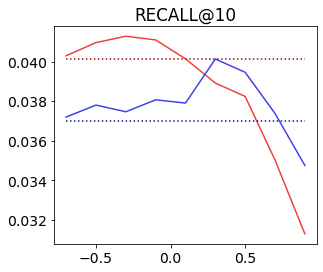

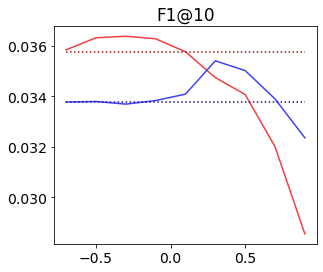

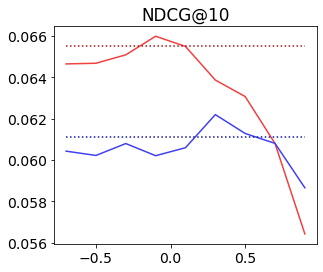

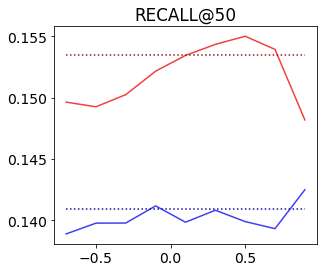

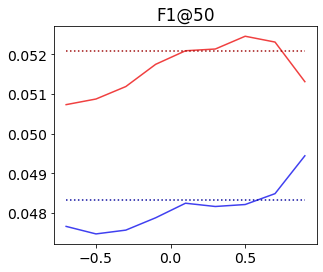

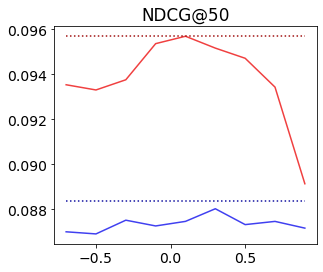

In [79]:
plt.rcParams.update({'font.size': 14})
selected_metrics = ['RECALL@10','F1@10','NDCG@10','RECALL@50','F1@50','NDCG@50']
model_colors = {'MF': '#a01010', 'FairMF': '#f04040', 'FedMF': '#1010a0', 'FedFairMF': '#4040f0'}
for i in range(len(selected_metrics)):
    plot_recommendation_over_lambda({'FairMF': fairmf_result, 'FedFairMF': fedfairmf_result}, selected_lambda, [selected_metrics[i]], 
                                    row_height = 4, ncol = 3, other_model_results = {'MF': mf_result, 'FedMF': fedmf_result}, 
                                    legend_appear_at = -1, colors = model_colors)